In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import cv2
import random
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [2]:
import os
import json
from detectron2.structures import BoxMode

def get_vidor_dicts(dataset_dir, mode):
    json_file = os.path.join(dataset_dir, mode + "_frame_annots_detectron2.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns):
        record = {}
        
        image_id = v['video_id'] + '_' + v['frame_id']
        filename = image_id + '.jpg'
        filename = os.path.join(dataset_dir, 'frames', v['video_folder'], v['video_id'], filename)
        
        record["file_name"] = filename
        record["image_id"] = image_id
        record["height"] = v['height']
        record["width"] = v['width']
      
        annos = v["objs"]
        objs = []
        for anno in annos:
            bbox = anno['bbox']
            obj = {
                "bbox": [bbox['xmin'], bbox['ymin'], bbox['xmax'], bbox['ymax']],
                "bbox_mode": BoxMode.XYXY_ABS,
                "category_id": anno['object_class'],
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [3]:
from detectron2.data import DatasetCatalog, MetadataCatalog

dataset_dir = os.path.join('slowfast', 'datasets', 'vidor')

with open(os.path.join(dataset_dir, 'obj_categories.json'), 'r') as f:
    obj_categories = json.load(f)

for d in ["train", "val"]:
    DatasetCatalog.register("vidor_" + d, lambda d=d: get_vidor_dicts(dataset_dir, d))
    MetadataCatalog.get("vidor_" + d).set(thing_classes=obj_categories)

In [4]:
vidor_metadata = MetadataCatalog.get("vidor_train")
dataset_dicts = get_vidor_dicts(dataset_dir, 'train')

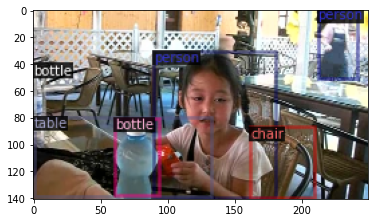

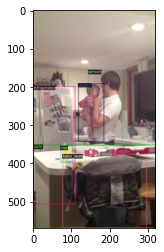

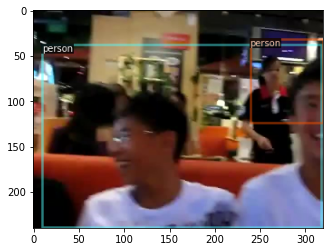

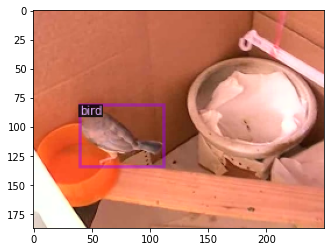

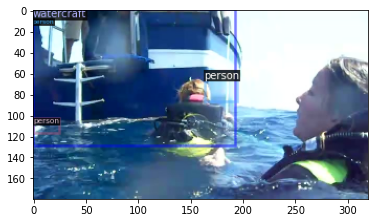

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

for d in random.sample(dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=vidor_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    # cv2.imshow(out.get_image()[:, :, ::-1])
    plt.imshow(cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

In [19]:
from detectron2.engine import DefaultTrainer, default_argument_parser, default_setup, hooks, launch
from detectron2.config import get_cfg

cfg = get_cfg()
# configs for training
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("vidor_train",)
# cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
factor = 4
cfg.SOLVER.IMS_PER_BATCH = 16 * factor
cfg.SOLVER.BASE_LR = 0.0001 * factor  
cfg.SOLVER.MAX_ITER = 270000 // factor 
cfg.SOLVER.STEPS = [210000 // factor, 250000 // factor]
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128 # default: 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 78

# configs for testing
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("vidor_val",)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.OUTPUT_DIR = './output/train_vidor_with_pseudo_labels'
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

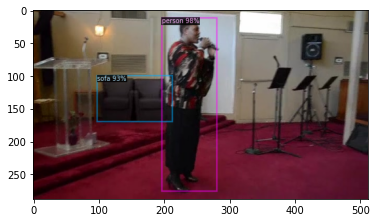

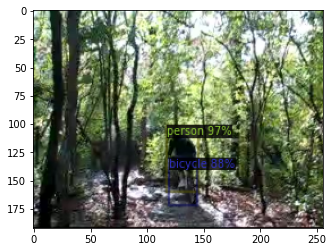

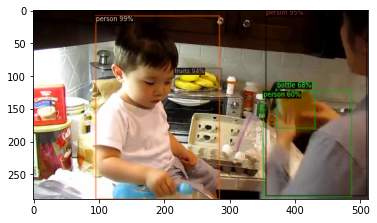

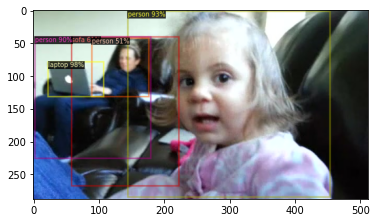

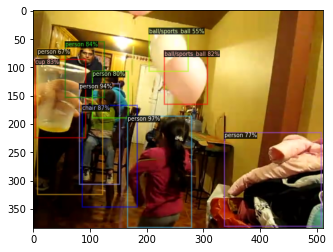

In [21]:
# Testing
predictor = DefaultPredictor(cfg)

from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_vidor_dicts(dataset_dir, 'val')
for d in random.sample(dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=vidor_metadata, 
                   scale=0.8, 
                   # instance_mo÷de=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )

    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

In [9]:
# Do some training...
# USE train_net_vidor.py INSTEAD!

# os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
# trainer.resume_or_load(resume=False)
# trainer.train()

[07/16 11:43:49 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[07/16 11:44:06 d2.data.build]: Removed 0 images with no usable annotations. 423850 images left.
[07/16 11:44:16 d2.data.common]: Serializing 423850 elements to byte tensors and concatenating them all ...
[07/16 11:44:19 d2.data.common]: Serialized dataset takes 138.92 MiB
[07/16 11:44:19 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[07/16 11:44:19 d2.data.build]: Using training sampler TrainingSampler


In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.checkpoint import DetectionCheckpointer

model = DefaultTrainer.build_model(cfg)
DetectionCheckpointer(model, save_dir=cfg.OUTPUT_DIR).resume_or_load(
    cfg.MODEL.WEIGHTS, resume=False
)

evaluator = COCOEvaluator("vidor_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "vidor_val")
inference_on_dataset(trainer.model, val_loader, evaluator)